In [3]:
#use of HTML files to get data

from bs4 import BeautifulSoup
import pandas as pd
import os

html_tables = {}

for table_name in os.listdir('datasets'):
    table_path = f'datasets/{table_name}'
    table_file = open(table_path, 'r')
    
    # scraping the HTML table using BeautifulSoup into html variable 
    html = BeautifulSoup(table_file)
    html_table = html.find(id="news-table")
    html_tables[table_name] = html_table

In [2]:
# extracting data from the files
tsla = html_tables['tsla_5june.html']
tsla_tr = tsla.findAll('tr')

# For each row
for i, table_row in enumerate(tsla_tr):
    link_text = table_row.a.get_text() # headlines
    data_text = table_row.td.get_text() # date & time of that headline
    # Print the count
    print(f'{i}:') 
    print(link_text)
    print(data_text)
    if i == 3:
        break

0:
Dow Jones Surges 850 Points On 'Amazing' Jobs Report; Apple Hits All-Time High, While Boeing Soars 15%
Jun-05-20 11:03AM  
1:
The Zacks Analyst Blog Highlights: JPMorgan Chase, Exxon Mobil, Oracle, Tesla and Royal Dutch Shell
10:07AM  
2:
The Zacks Analyst Blog Highlights: Lowe's Companies, Applied Materials, NVIDIA, Tesla and NextEra Energy
10:02AM  
3:
Tesla Stock Could Rally to $1,500
09:25AM  


In [3]:
# extracting the news headlines
parsed_news = []

for file_name, news_table in html_tables.items():
    for x in news_table.findAll('tr'):
        text = x.get_text() #ticker
        headline = x.a.get_text() #headline from anchor tag
        date_scrape = x.td.text.split() # to get date and time string

        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]
 
        ticker = file_name.split('_')[0]
        parsed_news.append([ticker, date, time, headline])

In [4]:
# using NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# making a dictionary of very frequently used words in financial market and assigning then their values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}

vader = SentimentIntensityAnalyzer()

vader.lexicon.update(new_words)

C:\Users\Parth Panday\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
#sentiment analysis using nltk
columns = ['ticker', 'date', 'time', 'headline']
scored_news = pd.DataFrame(parsed_news, columns=columns)
scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]
scores_df = pd.DataFrame(scores)
scored_news = pd.concat([scored_news, scores_df], axis=1)
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

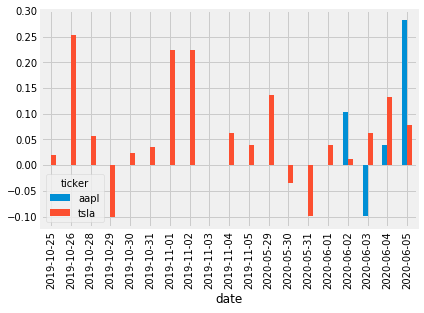

In [6]:
#plot the sentiment
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

mean_c = scored_news.groupby(['date', 'ticker']).mean()
mean_c = mean_c.unstack(level=1)
mean_c = mean_c.xs('compound', axis=1)
mean_c.plot.bar();

In [7]:
# removving the duplicate news
num_news_before = scored_news.headline.count()
scored_news_clean = scored_news.drop_duplicates(['ticker', 'headline'])

num_news_after = scored_news_clean.headline.count()

print(num_news_before)
print(num_news_after)

300
294


In [8]:
#sentiment on one single day for TESLA
single_day = scored_news_clean.set_index(['ticker', 'date'])

single_day = single_day.loc['tsla']
single_day = single_day.loc['2020-06-01']
print(single_day)

single_day['time'] = pd.to_datetime(single_day['time'])
single_day['time'] = single_day.time.dt.time

single_day.set_index('time', inplace=True)
single_day=single_day.sort_index(ascending=True)
single_day.head()

               time                                           headline  \
date                                                                     
2020-06-01  10:08PM  Geely's Polestar plans China showroom expansio...   
2020-06-01  10:00PM  Geely's Polestar plans China showroom expansio...   
2020-06-01  05:51PM  US Indexes Start the Month of June Slightly Hi...   
2020-06-01  05:42PM  The Dow Rose 92 Points Because Protests and U....   
2020-06-01  05:15PM     How Investors are Behaving in 2020 Versus 2008   
2020-06-01  05:09PM  SpaceX, NASA send astronauts into space in his...   
2020-06-01  05:07PM                   Why Tesla Stock Jumped on Monday   
2020-06-01  04:56PM  How SpaceX is 'revolutionizing the space indus...   
2020-06-01  04:38PM  Tesla, IBD Stock Of The Day, Breaks Out Into B...   
2020-06-01  04:35PM  SpaceX Falcon 9 Launch A 'Major Shot In The Ar...   
2020-06-01  03:52PM  Breakout Watch: Tesla Stock Gaps Up Into Buy Zone   
2020-06-01  03:47PM  Elon Musk demands

,headline,compound,neg,neu,pos
time,,,,,
05:54:00,"Elon Musk's Baby Has A Nickname, Grimes Reveals",-0.2500,0.250,0.750,0.000
07:15:00,Nio CEO Says Tesla An Ally In Increasing Sales...,0.3818,0.000,0.852,0.148
08:16:00,Dow Jones Futures: Tesla Leads 5 Stocks Lookin...,0.0000,0.000,1.000,0.000
09:39:00,Auto Stock Roundup: NSANY Incurs Biggest Loss ...,0.6908,0.108,0.610,0.282
10:15:00,Tesla Breaks Out,0.0000,0.000,1.000,0.000


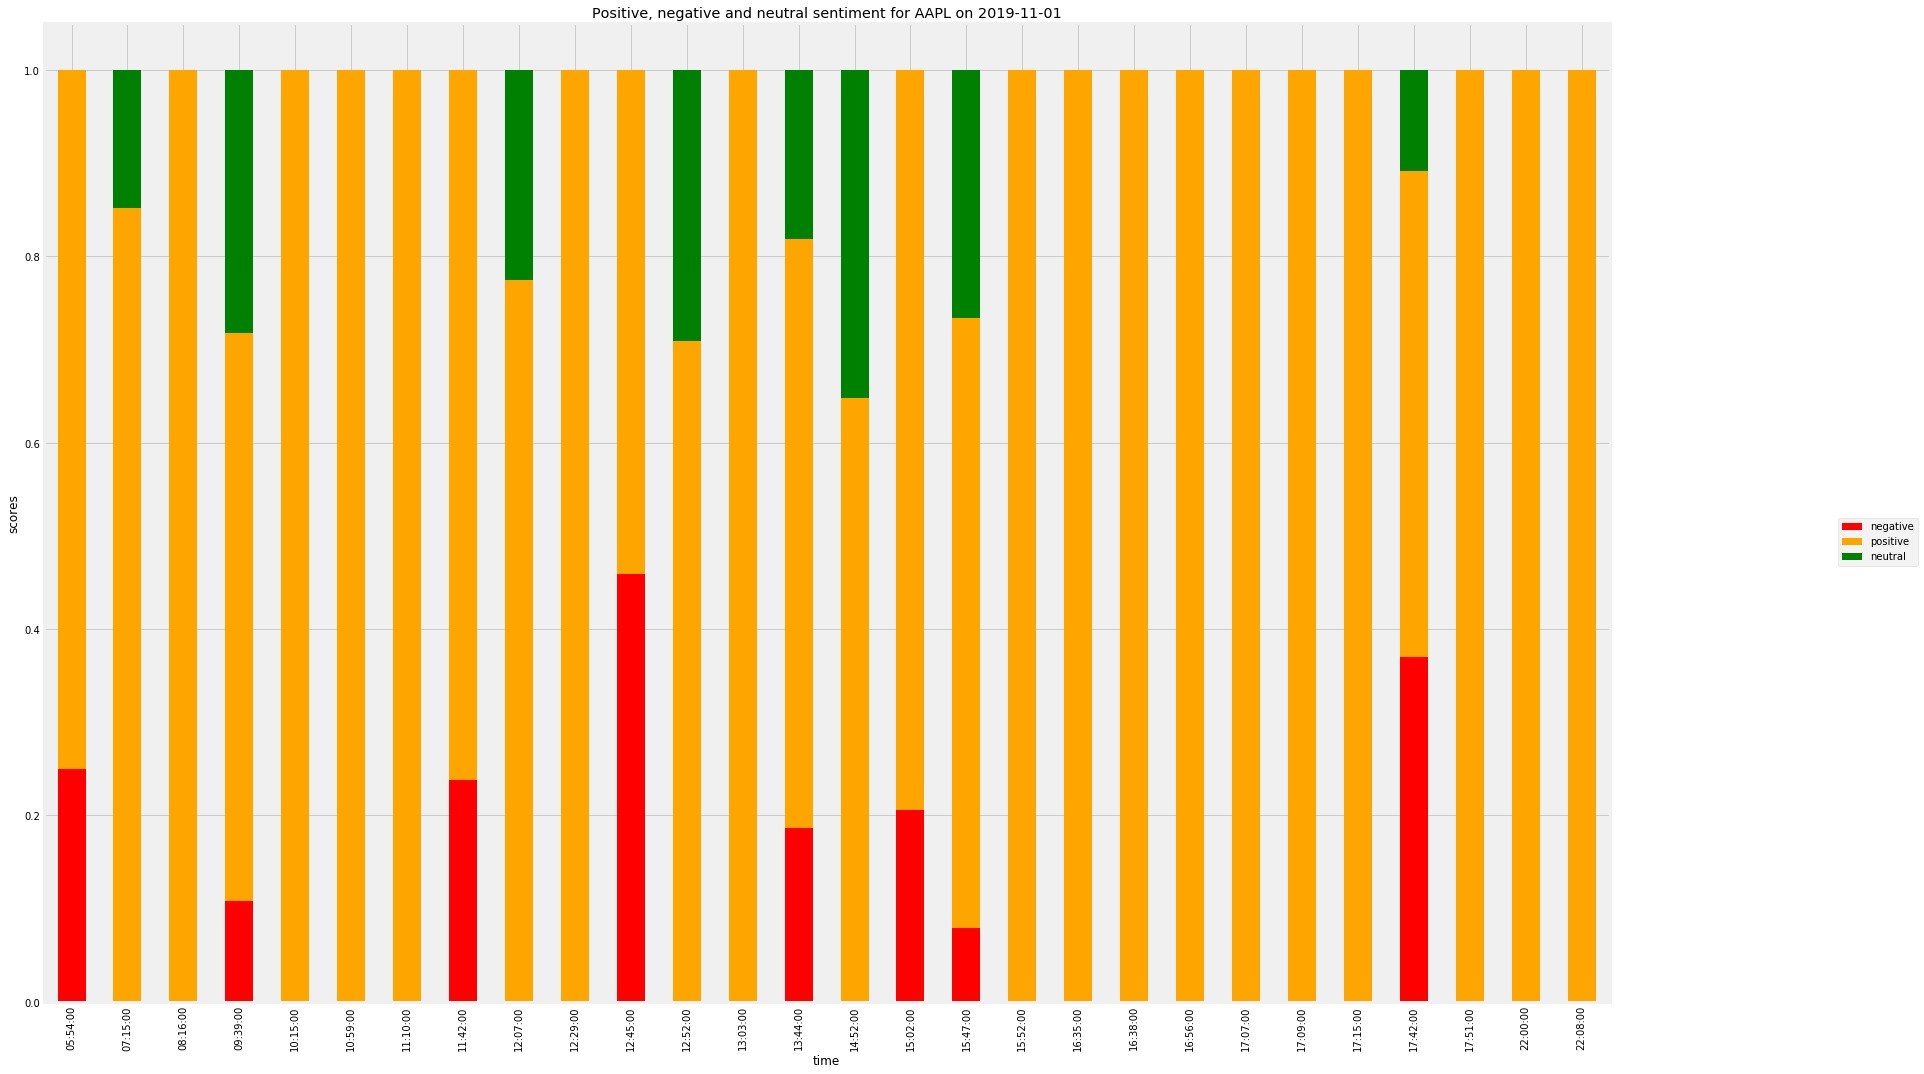

In [9]:
#visualize a single day
TITLE = "Positive, negative and neutral sentiment for TSLA on 2020-06-01"
COLORS = ["red", "orange", "green"]

plot_day = single_day.drop(['headline', 'compound'], axis=1)

plot_day.columns = ['negative', 'positive', 'neutral']

plot_day.plot.bar(stacked = True, 
                  figsize=(25, 18), 
                  title = TITLE, 
                  color = COLORS)
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");

In [10]:
#sentiment on one single day for APPLE
single_day = scored_news_clean.set_index(['ticker', 'date'])

single_day = single_day.loc['aapl']
single_day = single_day.loc['2020-06-04']
print(single_day)

single_day['time'] = pd.to_datetime(single_day['time'])
single_day['time'] = single_day.time.dt.time

single_day.set_index('time', inplace=True)
single_day=single_day.sort_index(ascending=True)
single_day.head()

               time                                           headline  \
date                                                                     
2020-06-04  09:00PM  Broadcom Suggests New iPhone Launch Will Be De...   
2020-06-04  07:10PM  Broadcom Warns of Weak Demand for Smartphone C...   
2020-06-04  06:48PM        Apple Posts Statement on George Floyd Death   
2020-06-04  05:58PM  Apple Offering Covid-19 Testing to Staff Retur...   
2020-06-04  04:15PM  Most Stocks Were Lifted in the Recent Rally. B...   
2020-06-04  04:11PM  Defending Apple TV+: Too Soon To Write Off Str...   
2020-06-04  03:04PM              Top 10 S&P 500 Stocks by Index Weight   
2020-06-04  02:08PM  GLOBAL MARKETS-ECB sends euro higher, stocks p...   
2020-06-04  01:46PM  Don't Count Out Apple TV+, Despite Lackluster ...   
2020-06-04  01:31PM  US STOCKS-Wall Street retreats after rallying ...   
2020-06-04  12:22PM  Apple TV+ Got a Slow Start. But Dont Count It ...   
2020-06-04  12:00PM  Watch out: This i

,headline,compound,neg,neu,pos
time,,,,,
00:38:00,Taiwan Draws Up Plan to Woo $1.3 Billion of An...,0.4767,0.000,0.780,0.220
06:06:00,Buffett's Portfolio Hasn't Done This in 4 Year...,0.0000,0.000,1.000,0.000
07:11:00,Europe pins hopes on smarter coronavirus conta...,0.7003,0.000,0.547,0.453
07:18:00,Spain's lower house opens process to create di...,-0.0258,0.154,0.699,0.147
08:39:00,Apple CEO Tim Cook Publishes Open Letter on Ra...,-0.6249,0.313,0.687,0.000


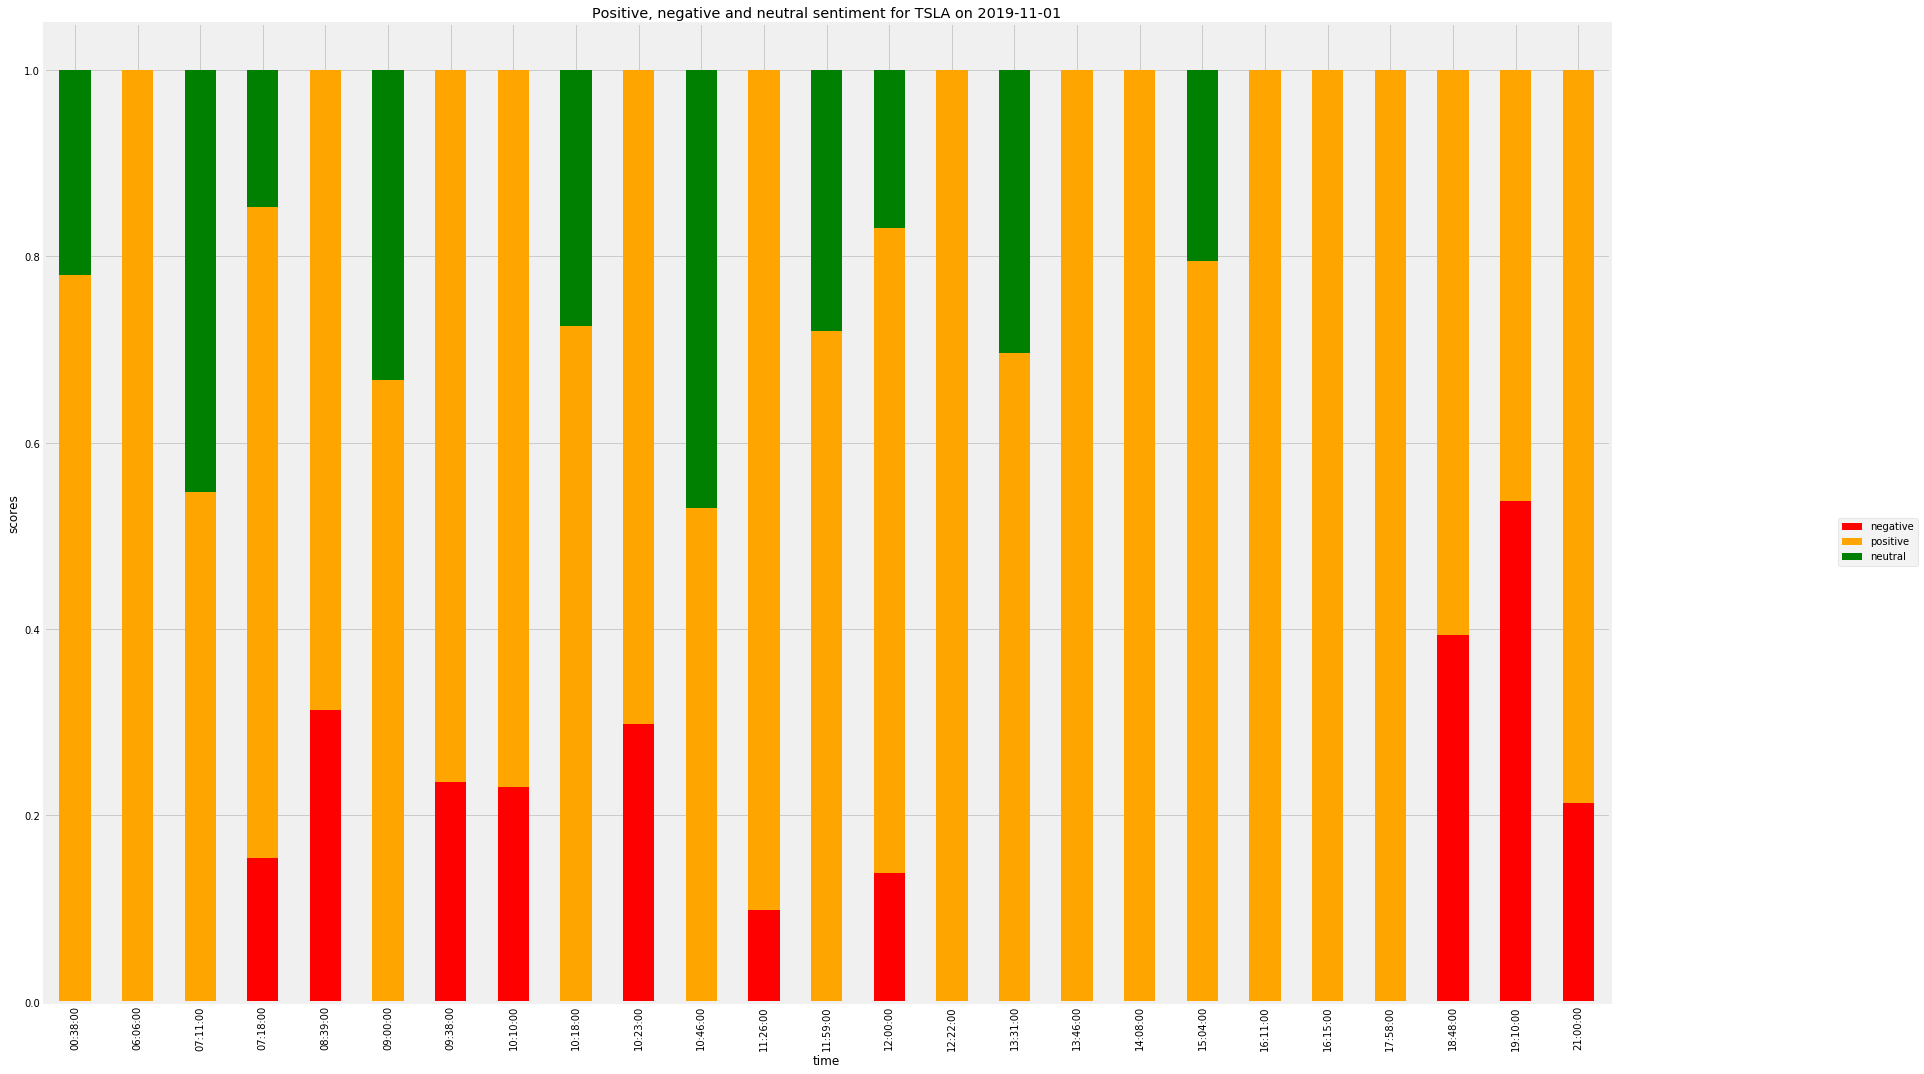

In [11]:
#visualize a single day
TITLE = "Positive, negative and neutral sentiment for AAPL on 2020-06-04"
COLORS = ["red", "orange", "green"]

plot_day = single_day.drop(['headline', 'compound'], axis=1)

plot_day.columns = ['negative', 'positive', 'neutral']

plot_day.plot.bar(stacked = True, 
                  figsize=(25, 18), 
                  title = TITLE, 
                  color = COLORS)
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");